In [1]:
import talib
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date
import bt 

ticker = "aapl"
today = date.today().strftime("%Y-%m-%d")
stock_data = yf.download(ticker, start="2020-1-1", end=today)


[*********************100%***********************]  1 of 1 completed


In [2]:
stock_data.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-04-16  134.300003  134.669998  133.279999  134.160004  134.160004   
2021-04-19  133.509995  135.470001  133.339996  134.839996  134.839996   
2021-04-20  135.020004  135.529999  131.809998  133.110001  133.110001   
2021-04-21  132.360001  133.750000  131.300003  133.500000  133.500000   
2021-04-22  133.039993  134.149994  131.413803  131.940002  131.940002   

              Volume  
Date                  
2021-04-16  84818500  
2021-04-19  93996100  
2021-04-20  94660400  
2021-04-21  68728500  
2021-04-22  84566356

In [3]:
EMA_short = talib.EMA(stock_data['Close'], timeperiod=12).to_frame()
EMA_short = EMA_short.rename(columns={0: 'Close'})
EMA_long = talib.EMA(stock_data['Close'], timeperiod=50).to_frame()
EMA_long = EMA_long.rename(columns={0: 'Close'})

In [4]:
signal = EMA_long.copy()
signal[EMA_long.isnull()] = 0
signal[EMA_short > EMA_long] = 1
signal[EMA_short < EMA_long] = -1

In [5]:
signal[50:250]

Close
Date             
2020-03-13   -1.0
2020-03-16   -1.0
2020-03-17   -1.0
2020-03-18   -1.0
2020-03-19   -1.0
...           ...
2020-12-18    1.0
2020-12-21    1.0
2020-12-22    1.0
2020-12-23    1.0
2020-12-24    1.0

[200 rows x 1 columns]

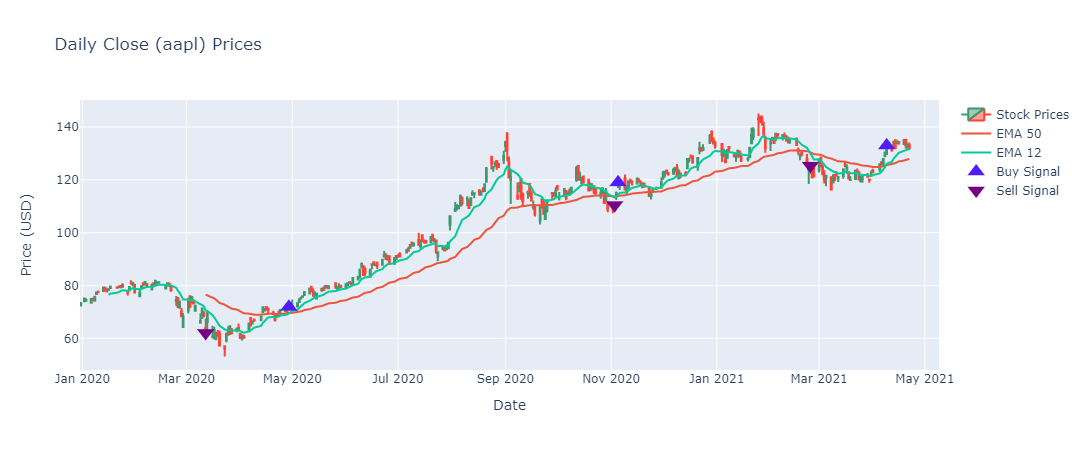

In [6]:
transition = signal[signal['Close'].diff() != 0]
buy_signal = transition[transition['Close'] == 1]
sell_signal = transition[transition['Close'] == -1]

buy_index = buy_signal.index
buy_position = stock_data[stock_data.index.isin(buy_index)]
sell_index = sell_signal.index
sell_position = stock_data[stock_data.index.isin(sell_index)]

fig = go.Figure()
fig.add_trace(
        go.Candlestick(x=stock_data.index,
                        open=stock_data['Open'],
                        high=stock_data['High'],
                        low=stock_data['Low'],
                        close=stock_data['Close'],
                        name="Stock Prices"
                      )              
)

fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=EMA_long['Close'],
            name="EMA 50"
        )
)

fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=EMA_short['Close'],
            name = "EMA 12"
        )
)

fig.add_trace(
        go.Scatter(
            x=buy_position.index,
            y=buy_position['Close'], 
            name="Buy Signal",
            marker=dict(color="#511CFB", size=15),
            mode="markers",
            marker_symbol="triangle-up"
        )
)

fig.add_trace(
        go.Scatter(
            x=sell_position.index,
            y=sell_position['Close'], 
            name="Sell Signal",
            marker=dict(color="#750086", size=15),
            mode="markers",
            marker_symbol="triangle-down"
        )
)

fig.update_layout(
    xaxis_rangeslider_visible=False,
    title="Daily Close (" + ticker + ") Prices",
    xaxis_title="Date",
    yaxis_title="Price (USD)"
)
fig.show()

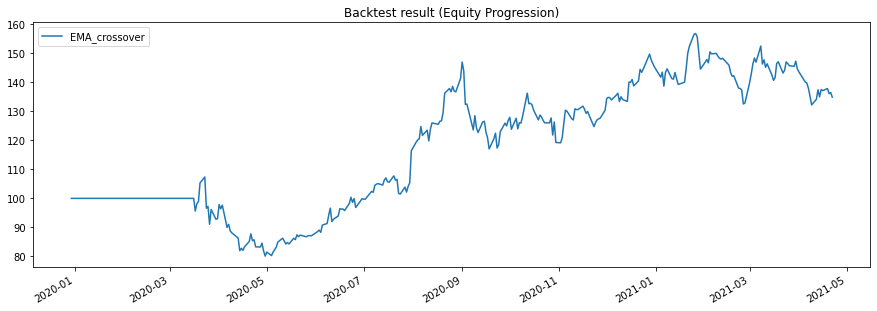

In [7]:
%matplotlib inline

bt_strategy = bt.Strategy('EMA_crossover',
                            [   bt.algos.RunWeekly(),
                                bt.algos.WeighTarget(signal),
                                bt.algos.Rebalance()
                            ]
                         )

bt_backtest = bt.Backtest(bt_strategy, stock_data['Close'].to_frame())
bt_result = bt.run(bt_backtest)
bt_result.plot(title='Backtest result (Equity Progression)')
plt.show()


Text(0.5, 0.98, 'weekly Return Histogram Matrix')

<Figure size 432x288 with 0 Axes>

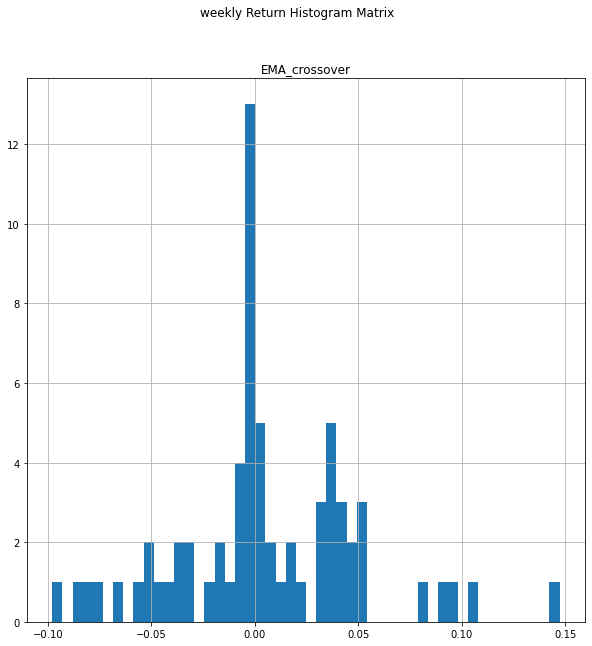

In [8]:
bt_result.plot_histograms(bins=50, freq = 'w')

In [9]:
bt_result.display()

Stat                 EMA_crossover
-------------------  ---------------
Start                2019-12-30
End                  2021-04-22
Risk-free rate       0.00%

Total Return         34.90%
Daily Sharpe         0.82
Daily Sortino        1.30
CAGR                 25.64%
Max Drawdown         -25.39%
Calmar Ratio         1.01

MTD                  -6.72%
3m                   -11.46%
6m                   6.38%
YTD                  -7.20%
1Y                   57.95%
3Y (ann.)            25.64%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  25.64%

Daily Sharpe         0.82
Daily Sortino        1.30
Daily Mean (ann.)    29.25%
Daily Vol (ann.)     35.69%
Daily Skew           -0.27
Daily Kurt           3.30
Best Day             10.47%
Worst Day            -10.03%

Monthly Sharpe       0.78
Monthly Sortino      1.80
Monthly Mean (ann.)  28.93%
Monthly Vol (ann.)   37.13%
Monthly Skew         0.21
Monthly Kurt         -1.19
Best Month           21.44%
Worst Month          